In [2]:
import sys
#!{sys.executable} -m pip install --upgrade gribscan
#!{sys.executable} -m pip install --upgrade varname
#!{sys.executable} -m pip install --upgrade intake-xarray # This clears the error `ValueError: No plugins loaded for this entry: zarr`

# make the notebook more readable:
import warnings
warnings.filterwarnings('ignore')

# Cloud feedback in the monsoon 2.0 data set

This notebook comprises my first peeps into the monsoon data set. The way data is accessed and presented is based on the foundations Lukas Kluft presented in his AES seminar and [later shared via github](https://gist.github.com/lkluft/d97a5edef6f1b42bc648a9089a7e03d7). We start with an overview over the monsoon data set, then look into cloud radiative effect (CRE) on a global scale and in smaller domains and compare them to each other.

## Overview over Monsoon 2.0

In [35]:
%matplotlib inline
import intake

import xarray as xr
import numpy  as np
import pandas as pd
import matplotlib.pyplot as plt
from   matplotlib import gridspec
from scipy import stats as scipy_stats
from tqdm.notebook import tqdm, trange

import cmocean
import datashader as ds
from datashader.mpl_ext import dsshow

import cartopy.crs as ccrs
import cartopy.feature as cf

import gribscan

cat_yaml = "/work/bd1154/highresmonsoon/experiments/monsoon2.yaml"
cat = intake.open_catalog(cat_yaml)

print("Available Monsoon 2.0 runs:\n", *list(cat))

Available Monsoon 2.0 runs:
 luk1000 luk1001 luk1002 luk1003 luk1010 luk1011 luk1020 luk1021 luk1022 luk1023 luk1030 luk1031 luk1040 luk1041 luk1042 luk1043 luk1103 luk1123 luk2000 luk2002 luk2003 luk3001 luk3002 luk3003 grids


In [38]:
def summary(data):
    print('\nDimensions:')
    for key, value in data.dims.items():
        print(key.ljust(20), ': ', value)

    print('\nVariables:')
#    print([d for d in data.data_vars])
    namedict = dict(zip(
        #[data[d].standard_name for d in data.data_vars], 
        [d for d in data.data_vars], 
        [list(data[d].attrs.values())[9] for d in data.data_vars]))
    for key, value in namedict.items():
        print(key.ljust(20), ': ', value)

def coarsen(dataset, compression=6, method='mean', base=4):
    ''' 
    the base has been chosen for the icon native grid:
    4 triangles can be joined to one. The grid ordering makes 
    this operation possible. 
    See: https://easy.gems.dkrz.de/Processing/playing_with_triangles/subsampling_and_averaging.html
    '''
    if method == 'mean':
        return mean_coarsen(dataset, compression, base)
    if method == 'isel':
        return isel_coarsen(dataset, compression, base)

def isel_coarsen(dataset, exp, base=4):
    return dataset.isel(cell=slice(0,None,4**compression), drop=True)

def mean_coarsen(dataset, exp, base=4):
    return dataset.coarsen(cell=base**exp).mean()

def add_cre(data):
    data['rout']   = ( data['rsut']   + data['rlut']   )
    data['routcs'] = ( data['rsutcs'] + data['rlutcs'] )
    data['rnet']   = data['rsdt'] - ( data['rsut']   + data['rlut']   )
    data['rnetcs'] = data['rsdt'] - ( data['rsutcs'] + data['rlutcs'] )
    data['cre_m']  = data['rnet'] - data['rnetcs']

    data['cre_sw'] = data['rsut'] - data['rsutcs']
    data['cre_lw'] = data['rlut'] - data['rlutcs']
    data['cre_2']  = data['rnet'] - data['rnetcs']

    data['albe']   = data['rsdt'] / data['rnet']
    data['albecs'] = data['rsdt'] / data['rnetcs']
    data['conv']   = data['rlut'] / data['rsdt']
    data['convcs'] = data['rlutcs'] / data['rsdt']
    return data

Update: Since I last used it (April 2022), 3D data has been added to the intake catalog. I had to adapt some of my code to the changes.

In [18]:
#del(data)
data = cat["luk1001"]['atm2d'].to_dask()
summary(data)        
data = cat["luk1001"]['atm3d'].to_dask()
summary(data)        


Dimensions:
time                 :  8785
cell                 :  20971520

Variables:
albedo               :  surface albedo
clivi                :  vertically integrated cloud ice
cllvi                :  vertically integrated cloud water
clt                  :  total cloud cover
cosmu0               :  cosine of the zenith angle for rad. heating
dew2                 :  2m dew point temperature
evspsbl              :  evaporation
hfls                 :  latent heat flux
hfss                 :  sensible heat flux
pr                   :  precipitation flux
prls                 :  large-scale precipitation flux (snow)
prw                  :  vertically integrated water vapour
ps                   :  surface air pressure
psl                  :  mean sea level pressure
ptp                  :  tropopause air pressure
qgvi                 :  vertically integrated graupel
qrvi                 :  vertically integrated rain
qsvi                 :  vertically integrated snow
rain_gsp_rate       

In [37]:
# sidenote: an example of a progressbar
# i'll leave it here, as a reference.
from tqdm.notebook import tqdm, trange 
with tqdm(total=400) as progressBar: # set total count for progressBar to 400
    for i in range(400):
        i = i * i * i  * i  * i
        i = i * i * i  * i  * i
        i = i * i * i  * i  * i
        i = i * i * i  * i  * i  
        i = i * i * i  * i  * i
        i = i * i * i  * i  * i
        progressBar.update(1) # increment by 1
# of course this implies knowledge about the process and it is not necessary
# linear, but it is nice for processes that take a few minutes

  0%|          | 0/400 [00:00<?, ?it/s]

## Coarsen

Working with the whole data set might not always be feasible. Especially if looking at a global domain, it is just very big. The following is rough visual test of whether compression does negatively influence the quality of the dataset.

In [29]:
runs = [runid for runid in cat if runid.startswith("luk100")]
runs

['luk1000', 'luk1001', 'luk1002', 'luk1003']

In [ ]:
fig = plt.figure(figsize=(18,4))
axs = []
axs.append(plt.subplot(141))
axs.append(plt.subplot(142, sharey = axs[0]))
axs.append(plt.subplot(143, sharey = axs[0]))
axs.append(plt.subplot(144, sharey = axs[0]))
var = 'clt'
var = 'cre_m'

ax = axs[0]

with tqdm(total=16) as progressBar:
    
    compression = 10
    for ens_member in runs:
        data = coarsen(cat[ens_member]['atm2d'].to_dask(), compression)
        data = add_cre(data)
        ax.plot(data[var].isel(time=slice(1, None, 96)).mean("cell"), label=ens_member)
        ax.set_xlabel('time')
        progressBar.update(1) 
    ax.legend()
    ax.set_title('subsampling: 4**' + str(compression) ) 

    ax = axs[1]
    compression = 10
    for ens_member in runs:
        data = coarsen(cat[ens_member]['atm2d'].to_dask(), compression, method='isel')
        data = add_cre(data)
        ax.plot(data[var].isel(time=slice(1, None, 96)).mean("cell"), label=ens_member)
        ax.set_xlabel('time')
        progressBar.update(1) 
    ax.legend()
    ax.set_title('subsampling: 4**' + str(compression) + ' (isel)' ) 
    
    ax = axs[2]
    compression = 6
    for ens_member in runs:
        data = coarsen(cat[ens_member]['atm2d'].to_dask(), compression)
        data = add_cre(data)
        ax.plot(data[var].isel(time=slice(1, None, 96)).mean("cell"), label=ens_member)
        ax.set_xlabel('time')
        progressBar.update(1) 
    ax.legend()
    ax.set_title('subsampling: 4**' + str(compression) ) 

    ax = axs[3]
    compression = 1
    for ens_member in runs:
        data = coarsen(cat[ens_member]['atm2d'].to_dask(), compression)
        data = add_cre(data)
        ax.plot(data[var].isel(time=slice(1, None, 96)).mean("cell"), label=ens_member)
        ax.set_xlabel('time')
        progressBar.update(1) 
    ax.legend()
    ax.set_title('subsampling: 4**' + str(compression) ) 

  0%|          | 0/16 [00:00<?, ?it/s]

In [ ]:
ens_member = 'luk1000'
start = 6 # of the time series, to cut off spin-up

linewidth = 0.7

# TOA radiation variables:
# rlut    :  toa outgoing longwave radiation
# rlutcs  :  toa outgoing clear-sky longwave radiation
# rsdt    :  toa incident shortwave radiation
# rsut    :  toa outgoing shortwave radiation
# rsutcs  :  toa outgoing clear-sky shortwave radiation
i = 0

fig = plt.figure(figsize=(18,6))
axs = []
axs.append(plt.subplot(111))
# axs.append(plt.subplot(122)) #, sharex = axs[0]))

# # example for custom progressBar
# 
#     for i in range(50):
#         time.sleep(1)
#         print("shahinnur.com")
#         progressBar.update(20)
with tqdm(total=600) as progressBar:
    for ens_member in cat.search("luk1000"):
    #    data = coarsen(cat[ens_member].to_dask())
    #    data.clt.isel(time=slice(1, None, 96)).mean("cell").plot(label=ens_member)
        data = coarsen(cat[ens_member].to_dask(), compression=6)
        data['rout']   = ( data['rsut']   + data['rlut']   )
        data['routcs'] = ( data['rsutcs'] + data['rlutcs'] )
        data['rnet']   = data['rsdt'] - ( data['rsut']   + data['rlut']   )
        data['rnetcs'] = data['rsdt'] - ( data['rsutcs'] + data['rlutcs'] )
        data['cre_m']  = data['rnet'] - data['rnetcs']

        data['swcre'] = data['rsut'] - data['rsutcs']
        data['lwcre'] = data['rlut'] - data['rlutcs']
        data['cre']   = data['swcre'] + data['lwcre']

        data['albe']   = data['rsdt'] / data['rnet']
        data['albecs'] = data['rsdt'] / data['rnetcs']
        data['conv']   = data['rlut'] / data['rsdt']
        data['convcs'] = data['rlutcs'] / data['rsdt']

        ax = axs[0]

        y = data['rnet'].isel(  time=slice(start, None, 96)).mean("cell")
        progressBar.update(20)
        x = data.time[slice(start, None, 96)]
        progressBar.update(20)
        ax.plot(x,y,label='all sky',   linewidth=linewidth, color='orange')
        progressBar.update(60)


        y = data['rnetcs'].isel(  time=slice(start, None, 96)).mean("cell")
        progressBar.update(20)
        x = data.time[slice(start, None, 96)]
        progressBar.update(20)
        ax.plot(x,y,label='clear sky',   linewidth=linewidth, color='black')
        progressBar.update(60)

        y = data['cre_sw'].isel(  time=slice(start, None, 96)).mean("cell")
        progressBar.update(20) 
        x = data.time[slice(start, None, 96)]
        progressBar.update(20) 
        ax.plot(x,y,label='swCRE',   linewidth=linewidth, color='blue')
        progressBar.update(60)

        y = data['cre_lw'].isel(  time=slice(start, None, 96)).mean("cell")
        progressBar.update(20)
        x = data.time[slice(start, None, 96)]
        progressBar.update(20)
        ax.plot(x,y,label='lwCRE',   linewidth=linewidth, color='red')
        progressBar.update(60)

        y = data['cre_m'].isel(  time=slice(start, None, 96)).mean("cell")
        progressBar.update(20) 
        x = data.time[slice(start, None, 96)]
        progressBar.update(20)
        ax.plot(x,y,label='CRE',   linewidth=linewidth, color='violet')
        progressBar.update(60)

        # y = data['cre_2'].isel(  time=slice(start, None, 96)).mean("cell")
        # progressBar.update(20)
        # x = data.time[slice(start, None, 96)]
        # progressBar.update(20)
        # ax.plot(x,y,label='CRE 2',   linewidth=linewidth, color='violet', linestyle='dotted')
        # progressBar.update(60)
    

#     ax = axs[1]
    
#     y = data['albe'].isel(  time=slice(start, None, 96)).mean("cell")
#     print(i) ;i +=1 
#     x = data.time[slice(start, None, 96)]
#     print(i) ;i +=1 
#     ax.plot(x,y,label='albedo',   linewidth=linewidth, color='green')
#     print(i) ;i +=100
    
#     y = data['albecs'].isel(  time=slice(start, None, 96)).mean("cell")
#     print(i) ;i +=1 
#     x = data.time[slice(start, None, 96)]
#     print(i) ;i +=1 
#     ax.plot(x,y,label='albedo cs',   linewidth=linewidth, color='grey')
#     print(i) ;i +=100
    
    
#     y = data['conv'].isel(  time=slice(start, None, 96)).mean("cell")
#     print(i) ;i +=1 
#     x = data.time[slice(start, None, 96)]
#     print(i) ;i +=1 
#     ax.plot(x,y,label='LW out / SW in',   linewidth=linewidth, color='orange')
#     print(i) ;i +=100
    
#     y = data['convcs'].isel(  time=slice(start, None, 96)).mean("cell")
#     print(i) ;i +=1 
#     x = data.time[slice(start, None, 96)]
#     print(i) ;i +=1 
#     ax.plot(x,y,label='LW out / SW in (cs)',   linewidth=linewidth, color='violet')
#     print(i) ;i +=100
    

    

for ax in axs:
    ax.legend()
    # remove repeating labels for ensembles:
    #hand, labl = ax.get_legend_handles_labels()
    #ax.legend(np.unique(labl))
    plt.sca(ax)
    plt.xticks(rotation=45)
    

axs[0].set_xlabel('model time')
axs[0].set_ylabel('W/m^2')

plt.show()

#for ens_member in cat.search("luk100"):
#    data = coarsen(cat[ens_member].to_dask())
#    data.clt.isel(time=slice(1, None, 96)).mean("cell").plot(label=ens_member)
#plt.legend()

In [10]:
ens_member = 'luk1000'
start = 36 # of the time series, to cut off spin-up

linewidth = 0.7

fig = plt.figure(figsize=(18,6))
axs = []
axs.append(plt.subplot(111))

with tqdm(total=600) as progressBar:
    for ens_member in cat.search("luk100"):
        data = coarsen(cat[ens_member].to_dask(), compression=6)
        ax = axs[0]

        y = data['clt'].isel(  time=slice(start, None, 96)).mean("cell")
        progressBar.update(20)
        x = data.time[slice(start, None, 96)]
        progressBar.update(20)
        ax.plot(x,y, linewidth=linewidth, color='blue')
        progressBar.update(60)

for ax in axs:
    ax.legend()
    # # remove repeating labels for ensembles:
    # hand, labl = ax.get_legend_handles_labels()
    # ax.legend(np.unique(labl))
    plt.sca(ax)
    plt.xticks(rotation=45)
    
axs[0].set_xlabel('model time')
axs[0].set_ylabel('global mean cloud amount')

plt.show()

  0%|          | 0/600 [00:00<?, ?it/s]

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


In [5]:
start = 12 # of the time series, to cut off spin-up
linewidth = 1

fig = plt.figure(figsize=(18,6))
axs = []
axs.append(plt.subplot(111))
# axs.append(plt.subplot(122)) #, sharex = axs[0]))
ax = axs[0]

with tqdm(total=600) as progressBar:
    ensemble = "luk100"
    label = "(Present-day)"
    for ens_member in cat.search(ensemble):
        data = coarsen(cat[ens_member].to_dask(), compression=6)
        data['cre_sw'] = data['rsutcs'] - data['rsut']
        data['cre_lw'] = data['rlutcs'] - data['rlut']
        data['cre']  = data['cre_sw'] + data['cre_lw']

        y = data['cre'].isel(  time=slice(start, None, 96)).mean("cell")
        progressBar.update(20) 
        x = data.time[slice(start, None, 96)]
        progressBar.update(20)
        ax.plot(x,y,label='CRE '+label,   linewidth=linewidth, color='black')
        progressBar.update(60)
        
    ensemble = "luk103"
    label = "(SST +1K)"
    for ens_member in cat.search(ensemble):
        data = coarsen(cat[ens_member].to_dask(), compression=6)
        data['cre_sw'] = data['rsutcs'] - data['rsut']
        data['cre_lw'] = data['rlutcs'] - data['rlut']
        data['cre']  = data['cre_sw'] + data['cre_lw']

        y = data['cre'].isel(  time=slice(start, None, 96)).mean("cell")
        progressBar.update(20) 
        x = data.time[slice(start, None, 96)]
        progressBar.update(20)
        ax.plot(x,y,label='CRE '+label,   linewidth=linewidth, color='red')
        progressBar.update(60)

for ax in axs:
    ax.legend()
    # remove repeating labels for ensembles:
    hand, labl = ax.get_legend_handles_labels()
    # h, l = ax.get_legend_handles_labels()
    # ax.legend(h, l)
    ax.legend([hand[0], hand[-1]], np.unique(labl))
    plt.sca(ax)
    plt.xticks(rotation=45)
    
axs[0].set_xlabel('model time')
axs[0].set_ylabel('CRE')

plt.show()

#for ens_member in cat.search("luk100"):
#    data = coarsen(cat[ens_member].to_dask())
#    data.clt.isel(time=slice(1, None, 96)).mean("cell").plot(label=ens_member)
#plt.legend()

  0%|          | 0/600 [00:00<?, ?it/s]

In [ ]:
start = 12 # of the time series, to cut off spin-up
linewidth = 1


fig = plt.figure(figsize=(8,3))
fig.suptitle('CRE time series')
# create grid for different subplots
spec = gridspec.GridSpec(ncols=2, nrows=1, width_ratios=[6, 1], wspace=0.0)
axs = [fig.add_subplot(spec[0]), fig.add_subplot(spec[1])]
axs[0].get_shared_y_axes().join(*axs)


ax = axs[0]

with tqdm(total=600) as progressBar:
    ensemble = "luk100"
    label = "(Present-day)"
    d1, d2 = [], []
    for ens_member in cat.search(ensemble):
        data = coarsen(cat[ens_member].to_dask(), compression=6)
        data['cre_sw'] = data['rsutcs'] - data['rsut']
        data['cre_lw'] = data['rlutcs'] - data['rlut']
        data['cre']  = data['cre_sw'] + data['cre_lw']

        y = data['cre'].isel(  time=slice(start, None, 96)).mean("cell")
        d1.append(y.values)
        progressBar.update(20) 
        x = data.time[slice(start, None, 96)]
        progressBar.update(20)
        ax.plot(x,y,label='CRE '+label,   linewidth=linewidth, color='black')
        progressBar.update(60)
    

    # axs[1].boxplot(, medianprops=dict(color='black', linewidth=3), )
        
    ensemble = "luk103"
    label = "(SST +1K)"
    for ens_member in cat.search(ensemble):
        data = coarsen(cat[ens_member].to_dask(), compression=6)
        data['cre_sw'] = data['rsutcs'] - data['rsut']
        data['cre_lw'] = data['rlutcs'] - data['rlut']
        data['cre']  = data['cre_sw'] + data['cre_lw']

        y = data['cre'].isel(  time=slice(start, None, 96)).mean("cell")
        d2.append(y.values)
        progressBar.update(20) 
        x = data.time[slice(start, None, 96)]
        progressBar.update(20)
        ax.plot(x,y,label='CRE '+label,   linewidth=linewidth, color='red')
        progressBar.update(60)
    
    d = [np.ravel(np.asarray(d1)), np.ravel(np.asarray(d2))]
    print(len(d), len(d[0]), type(d))
    bp = axs[1].boxplot(d, whis=(5,95),
                   patch_artist=True,
                   widths=(0.5, 0.5),
                   medianprops=dict(color='red', linewidth=3),
                   boxprops=dict(facecolor=None)
                  )
    
    for patch in bp['boxes']:
        patch.set(facecolor='white')

    


#for ax in axs:
ax.legend()
# remove repeating labels for ensembles:
hand, labl = ax.get_legend_handles_labels()
# h, l = ax.get_legend_handles_labels()
# ax.legend(h, l)
ax.legend([hand[0], hand[-1]], np.unique(labl))
plt.sca(ax)
plt.xticks(rotation=30)
    
axs[0].set_xlabel('model time')
axs[0].set_ylabel("CRE [$W/m^2$]")

axs[1].axis('off')


fig.savefig('./monsoon_timeseries.svg',dpi=350)
plt.show()

#for ens_member in cat.search("luk100"):
#    data = coarsen(cat[ens_member].to_dask())
#    data.clt.isel(time=slice(1, None, 96)).mean("cell").plot(label=ens_member)
#plt.legend()

In [28]:
import os
#os.listdir()
a = 'monsoon_timeseries.svg'
print(os.getcwd()+a)

/home/m/m300872monsoon_timeseries.svg


In [ ]:
ens_member = 'luk1000'
start = 6 # of the time series, to cut off spin-up
compression = 8 # 8 = r2b1, 320 global data points

fig = plt.figure(figsize=(18,6))
axs = []
axs.append(plt.subplot(111))
#axs.append(plt.subplot(122)) #, sharex = axs[0]))


# TOA radiation variables:
# rlut    :  toa outgoing longwave radiation
# rlutcs  :  toa outgoing clear-sky longwave radiation
# rsdt    :  toa incident shortwave radiation
# rsut    :  toa outgoing shortwave radiation
# rsutcs  :  toa outgoing clear-sky shortwave radiation

y = []
print("calc")
for ens_member in tqdm(cat.search("luk1001")):
#    data = coarsen(cat[ens_member].to_dask())
#    data.clt.isel(time=slice(1, None, 96)).mean("cell").plot(label=ens_member)
    data = cat[ens_member].to_dask()
    data['rnet']   = data['rsdt'] - ( data['rsut']   + data['rlut']   )
    data['rnetcs'] = data['rsdt'] - ( data['rsutcs'] + data['rlutcs'] )
    data['cre_m']  = data['rnet'] - data['rnetcs']
    
    point = data['cre_m'].mean('time').mean("cell")
    for attr in dir(point.values):
        print(attr)
    y.append(point)
    #x = data.time[slice(start, None, 96)]
    


In [ ]:
ax = axs[0]
print("plot\n", y[0].values)
for p in tqdm(y):
    # ax.boxplot(series)
    print(p.isel(cell=slice(0,None,4**compression).values) #np.var(p))
    
    
for ax in axs:
    # ax.legend()
    # # remove repeating labels for ensembles:
    # hand, labl = ax.get_legend_handles_labels()
    # ax.legend(np.unique(labl))
    # # rotate labels
    # plt.sca(ax)
    # plt.xticks(rotation=45)
    pass
    
axs[0].set_xlabel('model time')
axs[0].set_ylabel('net radiation budget')

plt.show()

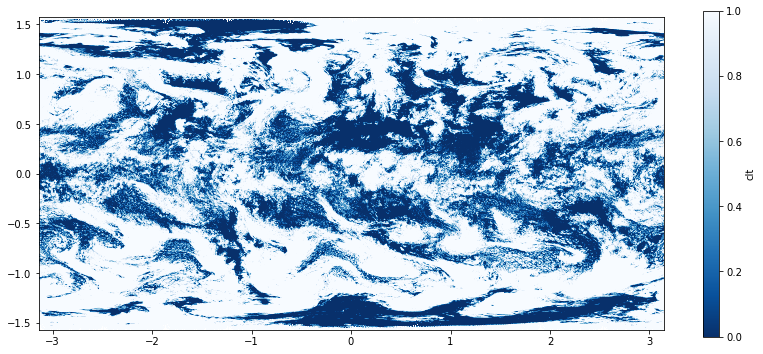

In [4]:
import cmocean
import datashader as ds
from datashader.mpl_ext import dsshow


data = cat["luk1001"].to_dask()
grid = cat.grids[data.uuidOfHGrid].to_dask()
dwg = data.merge(grid)

var = 'clt'

fig, ax = plt.subplots(figsize=(14, 6))
artist = ds.mpl_ext.dsshow(
    dwg[["clon", "clat", var]].isel(time=48 * 30),
    ds.Point("clon", "clat"),
    aggregator=ds.mean(var),
    cmap=plt.get_cmap('Blues').reversed(), #cmocean.cm.thermal,
#    vmin=260,
#   vmax=310,
    ax=ax,
)
fig.colorbar(artist, label=var)

In [9]:
import cartopy.crs as ccrs
import cartopy.feature as cf
import numpy as np
import pandas as pd

var = 'clt'
var = 'albedo'

# data
data = cat["luk1001"].to_dask()
# point coordinates
grid = cat.grids[data.uuidOfHGrid].to_dask()

projection = ccrs.Mollweide()
projection = ccrs.Robinson(central_longitude=-135.5808361)
projection = ccrs.PlateCarree()
projection = ccrs.InterruptedGoodeHomolosine(central_longitude=-135.5808361)
projection = ccrs.RotatedPole(pole_latitude=37.5, pole_longitude=177.5)

coords = projection.transform_points(
    ccrs.Geodetic(),
    np.rad2deg(grid.clon),
    np.rad2deg(grid.clat),
)

# figure
fig, ax = plt.subplots(figsize=(14, 6), subplot_kw={"projection": projection})
fig.canvas.draw() # ?
# Ist ein hack, um einen Bug (oder sowas in der Art) in datashader herum. 
# Aus irgendeinem Grund will datashader schon wissen wie groß ein Bild wird, bevor das Bild überhaupt erzeugt wird. 
# fig.canvas.draw_idle() macht ein dummy-Bild, was nicht wirklich gebraucht wird, aber halt macht, dass es funktioniert
# Siehe: https://github.com/holoviz/datashader/blob/master/datashader/mpl_ext.py#L386
# (Tobi)
ax.add_feature(cf.COASTLINE, linewidth=0.8)
ax.add_feature(cf.BORDERS, linewidth=0.4)



artist = dsshow(
    pd.DataFrame({
        "val": data[var].isel(time=( (48 + 6) * 60 )).values,
        "x": coords[:, 0],
        "y": coords[:, 1],
    }),
    ds.Point('x', 'y'),
    ds.mean('val'),
#    vmin=260,
#    vmax=310,
    cmap=plt.get_cmap('Blues').reversed(), #cmap=cmocean.cm.thermal,
    ax=ax,
)


fig.colorbar(artist, label=var)

In [ ]:
var = 'rsus'


#rlds                 :  surface downwelling longwave radiation
#rldscs               :  surface downwelling clear-sky longwave rad.
#rlus                 :  surface upwelling longwave radiation
#rlut                 :  toa outgoing longwave radiation
#rlutcs               :  toa outgoing clear-sky longwave radiation
#rsds                 :  surface downwelling shortwave radiation
#rsdscs               :  surface downwelling clear-sky shortwave rad.
#rsdt                 :  toa incident shortwave radiation
#rsus                 :  surface upwelling shortwave radiation
#rsuscs               :  surface upwelling clear-sky shortwave rad.
#rsut                 :  toa outgoing shortwave radiation
#rsutcs               :  toa outgoing clear-sky shortwave radiation

projection = ccrs.Mollweide()
coords = projection.transform_points(
    ccrs.Geodetic(),
    np.rad2deg(grid.clon),
    np.rad2deg(grid.clat),
)
data = cat["luk1001"].to_dask()
grid = cat.grids[data.uuidOfHGrid].to_dask()


fig, ax = plt.subplots(figsize=(14, 6), subplot_kw={"projection": projection})
fig.canvas.draw_idle()
ax.add_feature(cf.COASTLINE, linewidth=0.8)
ax.add_feature(cf.BORDERS, linewidth=0.4)
artist = dsshow(
    pd.DataFrame({
#        "val": data[var].isel(time=48 * 30).values,
        "val": data[var].mean('time').values,
        "x": coords[:, 0],
        "y": coords[:, 1],
    }),
    ds.Point('x', 'y'),
    ds.mean('val'),
#    vmin=260,
#    vmax=310,
    cmap=plt.get_cmap('Blues').reversed(), #cmap=cmocean.cm.thermal,
    ax=ax,
)
fig.colorbar(artist, label=var)

In [80]:
# ## Calculate zonal means ##
# Calculate the zonal-mean on the native ICON grid by
#  * counting all cells in a latitude bin
#  * calculate the sum over all values of a variable in a latitude bin

counts_per_bin, lat_bins = np.histogram(dwg.clat, bins=128, range=(-np.pi / 2, np.pi / 2))
varsum_per_bin, _ = np.histogram(dwg.clat, weights=dwg["tas"].isel(time=48*30), bins=lat_bins)

fig, ax = plt.subplots()
ax.plot(0.5 * (lat_bins[1:] + lat_bins[:-1]), varsum_per_bin / counts_per_bin)
ax.set_ylabel("tas / K")
ax.set_ylim(260, 310)
# Scale the x-axis to weight by the area of different latitudes
ax.set_xscale("function", functions=(lambda d: np.sin(d), lambda d: np.arcsin(d)))
ax.set_xlim(0.9 * lat_bins.min(), 0.9 * lat_bins.max())

(-1.413716694115407, 1.413716694115407)